In [24]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [230]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D
import pickle
from pathlib import Path
from nuscenes import NuScenes
from scipy.spatial.transform import Rotation as R 
from math import cos, sin, pi
from lyft_dataset_sdk.lyftdataset import *
from lyft_dataset_sdk.utils.data_classes import LidarPointCloud, Box, Quaternion
from lyft_dataset_sdk.utils.geometry_utils import view_points, transform_matrix

In [26]:
import torch
from google.protobuf import text_format
from second.utils import simplevis
from second.pytorch.train import build_network
from second.protos import pipeline_pb2
from second.utils import config_tool

In [27]:
lyft = LyftDataset(data_path='../../data/lyft/test/', json_path='../../data/lyft/test/v1.0-test/', verbose=0) 
nusc = NuScenes(dataroot='../../data/lyft/test/', version='v1.0-test', verbose=0) 

## Read Config file

In [28]:
config_path = "configs/nuscenes/all.fhd.config"
config = pipeline_pb2.TrainEvalPipelineConfig()
with open(config_path, "r") as f:
    proto_str = f.read()
    text_format.Merge(proto_str, config)
input_cfg = config.eval_input_reader
model_cfg = config.model.second
config_tool.change_detection_range_v2(model_cfg, [-50, -50, 50, 50])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

## Build Network, Target Assigner and Voxel Generator

In [29]:
ckpt_path = "/home/ags/second_test/all_fhd/voxelnet-11730.tckpt"
net = build_network(model_cfg).to(device).eval()
net.load_state_dict(torch.load(ckpt_path))
target_assigner = net.target_assigner
voxel_generator = net.voxel_generator
classes = target_assigner.classes

[  41 2000 2000]


## Generate Anchors

In [30]:
grid_size = voxel_generator.grid_size
feature_map_size = grid_size[:2] // config_tool.get_downsample_factor(model_cfg)
feature_map_size = [*feature_map_size, 1][::-1]

anchors = target_assigner.generate_anchors(feature_map_size)["anchors"]
anchors = torch.tensor(anchors, dtype=torch.float32, device=device)
anchors = anchors.view(1, -1, 7)

### utility functions

In [ ]:
def get_global_from_lidar(sample_token):
    sample_record = lyft.get("sample", sample_token) # get sample record
    lidar_record = lyft.get("sample_data", sample_record["data"]["LIDAR_TOP"])
    cs_record = lyft.get('calibrated_sensor', lidar_record['calibrated_sensor_token']) 
    ego_pose_record = lyft.get("ego_pose", lidar_record["ego_pose_token"])
    car_from_lidar = transform_matrix(cs_record['translation'], Quaternion(cs_record['rotation']), inverse=False)
    global_from_car = transform_matrix(ego_pose_record['translation'], Quaternion(ego_pose_record['rotation']), inverse=False)
    global_from_lidar = np.dot(global_from_car, car_from_lidar)
    return global_from_lidar

def transform_points(points, transf_matrix):
    """
    Transform (N, 3) or (N, 3) points using transformation matrix.
    """
    points = points.T
    points = np.vstack((points[:3, :], np.ones(points.shape[1])))  # 4xN
    new_points = transf_matrix.dot(points) # 4xN
    new_points = new_points[:3, :] # 3xN
    return new_points.T # Nx3

In [31]:
# info_path = input_cfg.dataset.kitti_info_path
# root_path = Path(input_cfg.dataset.kitti_root_path)
info_path = '../../data/lyft/test/infos_test.pkl'
root_path = '../../data/lyft/test/'
with open(info_path, 'rb') as f:
    infos = pickle.load(f)
sub = pd.read_csv('../../data/lyft/sample_submission.csv')
train = pd.read_csv('../../data/lyft/train.csv')

In [262]:
token2info = {}
for info in infos['infos']:
    token2info[info['token']] = info
    

In [270]:
def get_predictions(token):
    info = token2info[token]
    v_path = info["lidar_path"]
    points = np.fromfile(
        v_path, dtype=np.float32, count=-1).reshape([-1, 5])[:, :4]
    res = voxel_generator.generate(points, max_voxels=90000)
    voxels, coords, num_points = res['voxels'], res['coordinates'], res['num_points_per_voxel']
    #print(voxels.shape)
    # add batch idx to coords
    coords = np.pad(coords, ((0, 0), (1, 0)), mode='constant', constant_values=0)
    voxels = torch.tensor(voxels, dtype=torch.float32, device=device)
    coords = torch.tensor(coords, dtype=torch.int32, device=device)
    num_points = torch.tensor(num_points, dtype=torch.int32, device=device)
    example = {
        "anchors": anchors,
        "voxels": voxels,
        "num_points": num_points,
        "coordinates": coords,
    }
    pred = net(example)[0]
    return pred

In [271]:
for token in sub.Id.values:
    pred = get_predictions(token)
    break

In [168]:

boxes_lidar = pred["box3d_lidar"].detach().cpu().numpy()
boxes_class = pred["label_preds"]
scores = pred['scores'].detach().cpu().numpy()
boxes_lidar = boxes_lidar[scores>0.5]
boxes_class = boxes_class[scores>0.5]
boxes_scores = scores[scores>0.5]
preds_classes = [classes[x] for x in boxes_class]
box_centers = boxes_lidar[:, :3]
box_yaws = boxes_lidar[:, -1]
box_whl = boxes_lidar[:, 3:6]

# required translations: boxes to go from lidar to car then car to global coordinates
global_from_lidar = get_global_from_lidar(info['token'])

new_box_centers = transform_points(box_centers, global_from_lidar)

In [256]:
boxes = []
for idx in range(len(boxes_lidar)):
    translation = new_box_centers[idx]
    yaw = box_yaws[idx] - pi/2 # why pi/2??
    size = box_whl[idx]
    name = preds_classes[idx]
    detection_score = boxes_scores[idx]
#     r = R.from_dcm([
#         [cos(yaw), -sin(yaw), 0],
#         [sin(yaw),  cos(yaw), 0],
#         [   0,     0, 1],
#     ])  # a rotation matrix for rotation along z axis. 
#     quat = r.as_quat()
#     # XYZW -> WXYZ order of elements
#     quat = quat[[3,0,1,2]]
    quat = Quaternion(scalar=np.cos(yaw / 2), vector=[0, 0, np.sin(yaw / 2)]).inverse
    box = Box(
        center=box_centers[idx],
        size=size,
        orientation=quat,
        score=detection_score,
        name=name)
    boxes.append(box)

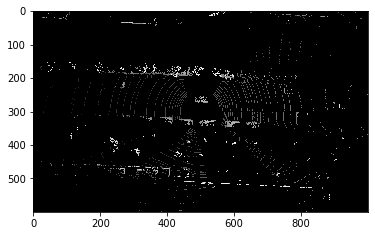

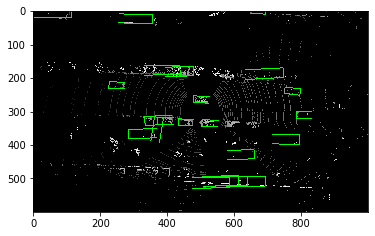

In [257]:
plt.imshow(org_bev_map); plt.show()
plt.imshow(bev_map)

In [258]:
sample = lyft.get('sample', info['token'])
lidar_token = sample['data']['LIDAR_TOP']
# lyft.render_sample_data(lidar_token)

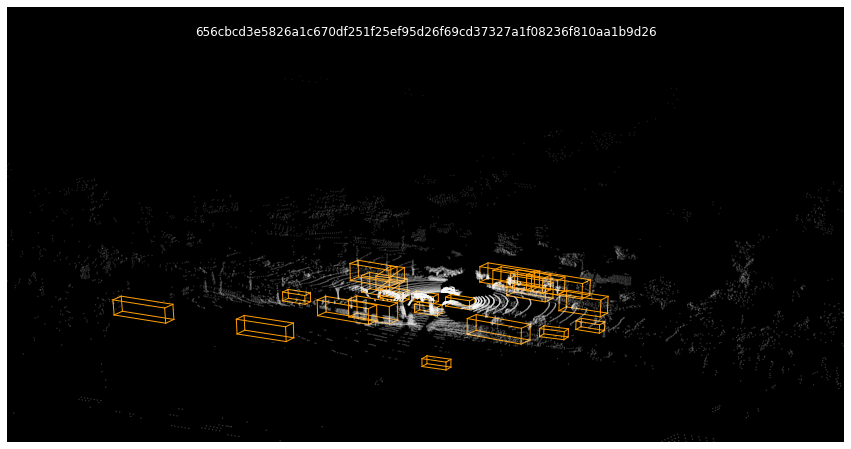

In [259]:
draw_3d_plot(lidar_token, boxes)

In [224]:
def plot_box(box, axis, view, colors, normalize=False, linewidth=1.0):
    '''Plot boxes in the 3d figure'''
    corners = view_points(box.corners(), view, normalize=normalize)#
    def draw_rect(selected_corners, color):
        prev = selected_corners[-1]
        for corner in selected_corners:
            axis.plot([prev[0], corner[0]], [prev[1], corner[1]], [prev[2], corner[2]], color=color, linewidth=linewidth)
            prev = corner

    # Draw the sides
    for i in range(4):
        axis.plot(
            [corners.T[i][0], corners.T[i + 4][0]],
            [corners.T[i][1], corners.T[i + 4][1]],
            [corners.T[i][2], corners.T[i + 4][2]],
            color=colors[2],
            linewidth=linewidth,
        )

    # Draw front (first 4 corners) and rear (last 4 corners) rectangles(3d)/lines(2d)
    draw_rect(corners.T[:4], colors[0]) #4x3
    draw_rect(corners.T[4:], colors[1])

In [211]:
def draw_3d_plot(lidar_token, boxes):
    '''Plot the lidar + annotations on a 3D figure'''
    # sample lidar point cloud
    lidar_points = get_lidar_points(lidar_token)
    points = 0.5 # fraction of lidar_points to plot, to reduce the clutter
    points_step = int(1. / points)
    pc_range = range(0, lidar_points.shape[1], points_step)
    lidar_points = lidar_points[:, pc_range]
    
    # Get boxes, instead of current sensor's coordinate frame, use vehicle frame which is aligned to z-plane in world
    #_, boxes, _ = lyft.get_sample_data(
    #    lidar_token, flat_vehicle_coordinates=True
    #)
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111, projection='3d')                    
    point_size = 0.01 * (1. / points) # size of the dots on plot
    ax.set_facecolor('black')
    ax.grid(False)
    ax.scatter(*lidar_points, s=point_size, c='white', cmap='gray')
    for box in boxes:
        c = np.array(lyft.explorer.get_color(box.name)) / 255.0
        plot_box(box, ax, view=np.eye(3), colors=(c, c, c), linewidth=1)
    ax.set_xlim3d(-40, 40)
    ax.set_ylim3d(-40, 40)
    ax.set_zlim3d(-4, 40)
    
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.set_title(lidar_token, color='white')
#     filename = 'tmp/frame_{0:0>4}.png'.format(idx)
#     plt.savefig(filename)
#     plt.close(fig)
    plt.show()
#     return filename

In [182]:
def get_lidar_points(lidar_token):
    '''Get lidar point cloud in the frame of the ego vehicle'''
    sd_record = lyft.get("sample_data", lidar_token)
    sensor_modality = sd_record["sensor_modality"]
    
    # Get aggregated point cloud in lidar frame.
    sample_rec = lyft.get("sample", sd_record["sample_token"])
    chan = sd_record["channel"]
    ref_chan = "LIDAR_TOP"
    pc, times = LidarPointCloud.from_file_multisweep(
        lyft, sample_rec, chan, ref_chan, num_sweeps=1
    )
    # Compute transformation matrices for lidar point cloud
    cs_record = lyft.get("calibrated_sensor", sd_record["calibrated_sensor_token"])
    pose_record = lyft.get("ego_pose", sd_record["ego_pose_token"])
    vehicle_from_sensor = np.eye(4)
    vehicle_from_sensor[:3, :3] = Quaternion(cs_record["rotation"]).rotation_matrix
    vehicle_from_sensor[:3, 3] = cs_record["translation"]
    
    ego_yaw = Quaternion(pose_record["rotation"]).yaw_pitch_roll[0]
    rot_vehicle_flat_from_vehicle = np.dot(
        Quaternion(scalar=np.cos(ego_yaw / 2), vector=[0, 0, np.sin(ego_yaw / 2)]).rotation_matrix,
        Quaternion(pose_record["rotation"]).inverse.rotation_matrix,
    )
    vehicle_flat_from_vehicle = np.eye(4)
    vehicle_flat_from_vehicle[:3, :3] = rot_vehicle_flat_from_vehicle
    points = view_points(
        pc.points[:3, :], np.dot(vehicle_flat_from_vehicle, vehicle_from_sensor), normalize=False
    )
    return points

In [183]:
pc = get_lidar_points(sample['data']['LIDAR_TOP'])

In [123]:
pred.keys()

dict_keys(['box3d_lidar', 'scores', 'label_preds', 'metadata'])

In [ ]:
vis_voxel_size = [0.1, 0.1, 0.1]
vis_point_range = [-50, -30, -3, 50, 30, 1]
org_bev_map = simplevis.point_to_vis_bev(points, vis_voxel_size, vis_point_range)
bev_map = simplevis.draw_box_in_bev(org_bev_map.copy(), vis_point_range, boxes_lidar, [0, 255, 0], 2)

In [28]:
box3d_lidar = pred['box3d_lidar']
scores = pred['scores']
label_preds = pred['label_preds']
metadata = pred['metadata']

In [32]:
box3d_lidar.shape

torch.Size([188, 7])

In [29]:
label_preds

tensor([0, 0, 0, 0, 0, 2, 2, 2, 0, 2, 2, 2, 6, 6, 2, 2, 6, 0, 0, 6, 6, 6, 2, 2,
        6, 6, 6, 6, 6, 6, 0, 2, 6, 6, 6, 6, 2, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6,
        6, 6, 2, 6, 2, 6, 6, 0, 6, 6, 6, 2, 2, 6, 6, 5, 6, 6, 6, 2, 2, 6, 6, 6,
        6, 2, 2, 6, 2, 6, 6, 6, 6, 2, 6, 6, 6, 6, 2, 6, 0, 6, 2, 6, 2, 6, 2, 6,
        6, 6, 6, 6, 5, 6, 6, 0, 6, 6, 0, 5, 2, 0, 1, 6, 6, 2, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 2, 6, 6, 6, 0, 6, 6, 6, 6, 6, 2, 0, 6, 2, 2, 6, 6, 6, 6, 6, 0,
        0, 6, 6, 6, 2, 6, 6, 0, 2, 5, 0, 6, 6, 6, 6, 6, 6, 6, 2, 2, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 2, 6, 2, 2, 6, 0, 6, 6, 2, 6, 6, 6, 2, 2, 6],
       device='cuda:0')

In [42]:
classes = target_assigner.classes

In [45]:

classes = target_assigner.classes
preds = [classes[x] for x in label_preds]
preds

['car',
 'car',
 'car',
 'car',
 'car',
 'bus',
 'bus',
 'bus',
 'car',
 'bus',
 'bus',
 'bus',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'car',
 'car',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'car',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'car',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'bus',
 'truck',
 'truck',
 'car',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'truck',
 'pedestrian',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'bus',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'bus',
 'truck',
 'car',
 'truck',
 'bus',
 'truck',
 'bus',
 'truck',
 'bus',
 'truck',
 'truck',
 'truck',
 'truck',
 'truck',
 'pedestrian',
 'truck',
 'truck',
 'car',
 'truck',
 'truck',
 'car',


In [ ]:
sub = {}
for i in tqdm_notebook(range(len(pred_box3ds))):
    pred =  str(pred_box3ds[i].score/255) + ' ' + str(pred_box3ds[i].center_x)  + ' '  + \
    str(pred_box3ds[i].center_y) + ' '  + str(pred_box3ds[i].center_z) + ' '  + \
    str(pred_box3ds[i].width) + ' ' \
    + str(pred_box3ds[i].length) + ' '  + str(pred_box3ds[i].height) + ' ' + str(pred_box3ds[i].rotation[-1]) + ' ' \
    + str(pred_box3ds[i].name) + ' ' 
        
    if pred_box3ds[i].sample_token in sub.keys():     
        sub[pred_box3ds[i].sample_token] = sub[pred_box3ds[i].sample_token] + pred
    else:
        sub[pred_box3ds[i].sample_token] = pred        
    
sample_sub = pd.read_csv('../input/3d-object-detection-for-autonomous-vehicles/sample_submission.csv')
for token in set(sample_sub.Id.values).difference(sub.keys()):
    print(token)
    sub[token] = ''

In [ ]:
sub = pd.DataFrame(list(sub.items()))
sub.columns = sample_sub.columns
sub.head()

In [ ]:
img_id = train.iloc[0]['Id']
ps = train.iloc[0]['PredictionString']
ps = ps.split()
objects = [ps[x:x+8] for x in range(0, len(ps), 8)]
len(objects), objects[0]